# SMNA mobile {#sec-SMNA_mobile}
This appendix is a template notebook for running SMNA using Google Colab on a mobile device, such as a phone. When using the free version of Colab, it's somewhat inconvenient to import the ```SymMNA.py``` functions, so in this notebook these functions are inserted in line. Running a schematic capture program on a mobile phone is not very practical, so when analyzing new circuits, the netlist will need to be generated and intered by hand.
<!--
Last update: 2 Jan 2025
-->

In [1]:
from sympy import *
import numpy as np
from tabulate import tabulate
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Markdown, Math, Latex
init_printing()

The file ```SymMNA.py``` was copied into the cell below. Click on the lable to expose the code.

In [2]:
#| code-fold: true

def get_part_values(net_df):
    """ construct a dictionary of element values from the netlist dataframe: value_dict, get_part_values
    Parameters
    ----------
    net_df: pandas dataframe
        the network dataframe returned by the smna function below
    Returns
    -------
    element values: Python dictionary
        the element values from the netlist
    """

    # initialize variables
    element_value_keys = []
    element_value_values = []

    for i in range(len(net_df)):
        if net_df.iloc[i]['element'][0] == 'F' or net_df.iloc[i]['element'][0] == 'E' or net_df.iloc[i]['element'][0] == 'G' or net_df.iloc[i]['element'][0] == 'H':
            element_value_keys.append(var(net_df.iloc[i]['element'].lower()))
            element_value_values.append(net_df.iloc[i]['value'])
        else:
            element_value_keys.append(var(net_df.iloc[i]['element']))
            element_value_values.append(net_df.iloc[i]['value'])

    return dict(zip(element_value_keys, element_value_values))

def smna(net_list):
    """Symbolic modified nodal analysis
    Parameters
    ----------
    net_list: str
        The circuit net list, needs a \n at the end of each line
    Returns
    -------
    report: text string
            The net list report.
    df: pandas dataframe
            circuit net list info loaded into a dataframe
    df2: pandas dataframe
            branches with unknown currents
    A: SymPy matrix
            The A matrix is (m+n) by (m+n) and is the combination of 4 smaller matrices, G, B, C, and D.
            The G matrix is n by n, where n is the number of nodes. The matrix is formed by the interconnections
            between the resistors, capacitors and VCCS type elements. In the original paper G is called Yr, 
            where Yr is a reduced form of the nodal matrix excluding the contributions due to voltage 
            sources, current controlling elements, etc. In Python row and columns are: G[row, column]
            The B matrix is an n by m matrix with only 0, 1 and -1 elements, where n = number of nodes
            and m is the number of current unknowns, i_unk. There is one column for each unknown current.
            The code loop through all the branches and process elements that have stamps for the B matrix: 
            The C matrix is an m by n matrix with only 0, 1 and -1 elements (except for controlled sources).
            The code is similar to the B matrix code, except the indices are swapped. The code loops through 
            all the branches and process elements that have stamps for the C matrix: 
            The D matrix is an m by m matrix, where m is the number of unknown currents. 
    X: list
            The X matrix is an (n+m) by 1 vector that holds the unknown quantities (node voltages 
            and the currents through the independent voltage sources). The top n elements are the n node 
            voltages. The bottom m elements represent the currents through the m independent voltage 
            sources in the circuit. The V matrix is n by 1 and holds the unknown voltages. The J matrix 
            is m by 1 and holds the unknown currents through the voltage sources
    Z: list
            The Z matrix holds the independent voltage and current sources and is the combination
            of 2 smaller matrices I and Ev. The Z matrix is (m+n) by 1, n is the number of nodes, 
            and m is the number of independent voltage sources. The I matrix is n by 1 and contains 
            the sum of the currents through the passive elements into the corresponding node (either 
            zero, or the sum of independent current sources). The Ev matrix is m by 1 and holds the 
            values of the independent voltage sources.
    """

    # initialize variables
    num_rlc = 0 # number of passive elements
    num_res = 0 # number of resistors
    num_cap = 0 # number of capacitors
    num_ind = 0 # number of inductors
    num_v = 0    # number of independent voltage sources
    num_i = 0    # number of independent current sources
    i_unk = 0  # number of current unknowns
    num_opamps = 0   # number of Op Amps
    num_vcvs = 0     # number of controlled sources of various types
    num_vccs = 0
    num_cccs = 0
    num_ccvs = 0
    num_cpld_ind = 0 # number of coupled inductors

    content = net_list.splitlines()

    content = [x.strip() for x in content]  #remove leading and trailing white space
    # remove empty lines
    while '' in content:
        content.pop(content.index(''))

    # remove comment lines, these start with a asterisk *
    content = [n for n in content if not n.startswith('*')]
    # remove other comment lines, these start with a semicolon ;
    content = [n for n in content if not n.startswith(';')]
    # remove spice directives, these start with a period, .
    content = [n for n in content if not n.startswith('.')]
    # converts 1st letter to upper case
    #content = [x.upper() for x in content] <- this converts all to upper case
    content = [x.capitalize() for x in content]
    # removes extra spaces between entries
    content = [' '.join(x.split()) for x in content]

    line_cnt = len(content) # number of lines in the netlist
    branch_cnt = 0  # number of branches in the netlist
    # check number of entries on each line, count each element type
    for i in range(line_cnt):
        x = content[i][0]
        tk_cnt = len(content[i].split()) # split the line into a list of words

        if (x == 'R') or (x == 'L') or (x == 'C'):
            if tk_cnt != 4:
                raise Exception("branch {:d} not formatted correctly, {:s} ".format(i,content[i]),
                "had {:d} items and should only be 4".format(tk_cnt))
            num_rlc += 1
            branch_cnt += 1
            if x == 'R':
                num_res += 1            
            if x == 'C':
                num_cap += 1            
            if x == 'L':
                num_ind += 1
        elif x == 'V':
            if tk_cnt != 4:
                raise Exception("branch {:d} not formatted correctly, {:s} ".format(i,content[i]),
                "had {:d} items and should only be 4".format(tk_cnt))
            num_v += 1
            branch_cnt += 1
        elif x == 'I':
            if tk_cnt != 4:
                raise Exception("branch {:d} not formatted correctly, {:s} ".format(i,content[i]),
                "had {:d} items and should only be 4".format(tk_cnt))
            num_i += 1
            branch_cnt += 1
        elif x == 'O':
            if tk_cnt != 4:
                raise Exception("branch {:d} not formatted correctly, {:s} ".format(i,content[i]),
                "had {:d} items and should only be 4".format(tk_cnt))
            num_opamps += 1
        elif x == 'E':
            if (tk_cnt != 6):
                raise Exception("branch {:d} not formatted correctly, {:s} ".format(i,content[i]),
                "had {:d} items and should only be 6".format(tk_cnt))
            num_vcvs += 1
            branch_cnt += 1
        elif x == 'G':
            if (tk_cnt != 6):
                raise Exception("branch {:d} not formatted correctly, {:s} ".format(i,content[i]),
                "had {:d} items and should only be 6".format(tk_cnt))
            num_vccs += 1
            branch_cnt += 1
        elif x == 'F':
            if (tk_cnt != 5):
                raise Exception("branch {:d} not formatted correctly, {:s} ".format(i,content[i]),
                "had {:d} items and should only be 5".format(tk_cnt))
            num_cccs += 1
            branch_cnt += 1
        elif x == 'H':
            if (tk_cnt != 5):
                raise Exception("branch {:d} not formatted correctly, {:s} ".format(i,content[i]),
                "had {:d} items and should only be 5".format(tk_cnt))
            num_ccvs += 1
            branch_cnt += 1
        elif x == 'K':
            if (tk_cnt != 4):
                raise Exception("branch {:d} not formatted correctly, {:s} ".format(i,content[i]),
                "had {:d} items and should only be 4".format(tk_cnt))
            num_cpld_ind += 1
        else:
            raise Exception("unknown element type in branch {:d}: {:s}".format(i,content[i]))


    ''' The parser performs the following operations.
     1. puts branch elements into data frame  
     2. counts number of nodes  

     data frame labels:
     - element: type of element  
     - p node: positive node  
     - n node: negative node, for a current source, the arrow point terminal, LTSpice 
     puts the inductor phasing dot on this terminal  
     - cp node: controlling positive node of branch  
     - cn node: controlling negative node of branch  
     - Vout: Op Amp output node  
     - value: value of element or voltage  
     - Vname: voltage source through which the controlling current flows. Need to 
     add a zero volt voltage source to the controlling branch.  
     - Lname1: name of coupled inductor 1  
     - Lname2: name of coupled inductor 2'''  

    # build the pandas data frame
    df = pd.DataFrame(columns=['element','p node','n node','cp node','cn node',
        'Vout','value','Vname','Lname1','Lname2'])

    # this data frame is for branches with unknown currents
    df2 = pd.DataFrame(columns=['element','p node','n node'])


    # ### Functions to load branch elements into data frame and check for gaps in node numbering

    # loads voltage or current sources into branch structure
    def indep_source(line_nu):
        tk = content[line_nu].split()
        df.loc[line_nu,'element'] = tk[0]
        df.loc[line_nu,'p node'] = int(tk[1])
        df.loc[line_nu,'n node'] = int(tk[2])
        df.loc[line_nu,'value'] = float(tk[3])

    # loads passive elements into branch structure
    def rlc_element(line_nu):
        tk = content[line_nu].split()
        df.loc[line_nu,'element'] = tk[0]
        df.loc[line_nu,'p node'] = int(tk[1])
        df.loc[line_nu,'n node'] = int(tk[2])
        df.loc[line_nu,'value'] = float(tk[3])

    # loads multi-terminal elements into branch structure
    # O - Op Amps
    def opamp_sub_network(line_nu):
        tk = content[line_nu].split()
        df.loc[line_nu,'element'] = tk[0]
        df.loc[line_nu,'p node'] = int(tk[1])
        df.loc[line_nu,'n node'] = int(tk[2])
        df.loc[line_nu,'Vout'] = int(tk[3])

    # G - VCCS
    def vccs_sub_network(line_nu):
        tk = content[line_nu].split()
        df.loc[line_nu,'element'] = tk[0]
        df.loc[line_nu,'p node'] = int(tk[1])
        df.loc[line_nu,'n node'] = int(tk[2])
        df.loc[line_nu,'cp node'] = int(tk[3])
        df.loc[line_nu,'cn node'] = int(tk[4])
        df.loc[line_nu,'value'] = float(tk[5])

    # E - VCVS
    # in sympy E is the number 2.718, replacing E with Ea otherwise, sympify() errors out
    def vcvs_sub_network(line_nu):
        tk = content[line_nu].split()
        df.loc[line_nu,'element'] = tk[0].replace('E', 'Ea')
        df.loc[line_nu,'p node'] = int(tk[1])
        df.loc[line_nu,'n node'] = int(tk[2])
        df.loc[line_nu,'cp node'] = int(tk[3])
        df.loc[line_nu,'cn node'] = int(tk[4])
        df.loc[line_nu,'value'] = float(tk[5])

    # F - CCCS
    def cccs_sub_network(line_nu):
        tk = content[line_nu].split()
        df.loc[line_nu,'element'] = tk[0]
        df.loc[line_nu,'p node'] = int(tk[1])
        df.loc[line_nu,'n node'] = int(tk[2])
        df.loc[line_nu,'Vname'] = tk[3].capitalize()
        df.loc[line_nu,'value'] = float(tk[4])

    # H - CCVS
    def ccvs_sub_network(line_nu):
        tk = content[line_nu].split()
        df.loc[line_nu,'element'] = tk[0]
        df.loc[line_nu,'p node'] = int(tk[1])
        df.loc[line_nu,'n node'] = int(tk[2])
        df.loc[line_nu,'Vname'] = tk[3].capitalize()
        df.loc[line_nu,'value'] = float(tk[4])

    # K - Coupled inductors
    def cpld_ind_sub_network(line_nu):
        tk = content[line_nu].split()
        df.loc[line_nu,'element'] = tk[0]
        df.loc[line_nu,'Lname1'] = tk[1].capitalize()
        df.loc[line_nu,'Lname2'] = tk[2].capitalize()
        df.loc[line_nu,'value'] = float(tk[3])

    # function to scan df and get largest node number
    def count_nodes():
        # need to check that nodes are consecutive
        # fill array with node numbers
        p = np.zeros(line_cnt+1)
        for i in range(line_cnt):
            # need to skip coupled inductor 'K' statements
            if df.loc[i,'element'][0] != 'K': #get 1st letter of element name
                p[df['p node'][i]] = df['p node'][i]
                p[df['n node'][i]] = df['n node'][i]

        # find the largest node number
        if df['n node'].max() > df['p node'].max():
            largest = df['n node'].max()
        else:
            largest =  df['p node'].max()

        largest = int(largest)
        # check for unfilled elements, skip node 0
        for i in range(1,largest):
            if p[i] == 0:
                raise Exception('nodes not in continuous order, node {:.0f} is missing'.format(p[i-1]+1))
        return largest

    # load branch info into data frame
    for i in range(line_cnt):
        x = content[i][0]

        if (x == 'R') or (x == 'L') or (x == 'C'):
            rlc_element(i)
        elif (x == 'V') or (x == 'I'):
            indep_source(i)
        elif x == 'O':
            opamp_sub_network(i)
        elif x == 'E':
            vcvs_sub_network(i)
        elif x == 'G':
            vccs_sub_network(i)
        elif x == 'F':
            cccs_sub_network(i)
        elif x == 'H':
            ccvs_sub_network(i)
        elif x == 'K':
            cpld_ind_sub_network(i)
        else:
            raise Exception("unknown element type in branch {:d}, {:s}".format(i,content[i]))

    '''29 Nov 2023:  When the D matrix is built, independent voltage sources are processed
    in the data frame order when building the D matrix. If the voltage source followed element
    L, H, F, K types in the netlist, a row was inserted that put the voltage source in a different
    row in relation to its position in the Ev matrix. This would cause the node attached to 
    the terminal of the voltage source to be zero volts.  
    Solution - The following block of code was added to move voltage source types to the 
    beginning of the net list dataframe before any calculations are performed.''' 

    # Check for position of voltage sources in the dataframe.
    source_index = [] # keep track of voltage source row number
    other_index = [] # make a list of all other types
    for i in range(len(df)):
        # process all the elements creating unknown currents
        x = df.loc[i,'element'][0]   #get 1st letter of element name
        if (x == 'V'):
            source_index.append(i)
        else:
            other_index.append(i)

    df = df.reindex(source_index+other_index,copy=True) # reorder the data frame
    df.reset_index(drop=True, inplace=True) # renumber the index

    # count number of nodes
    num_nodes = count_nodes()

    # Build df2: consists of branches with current unknowns, used for C & D matrices
    # walk through data frame and find these parameters
    count = 0
    for i in range(len(df)):
        # process all the elements creating unknown currents
        x = df.loc[i,'element'][0]   #get 1st letter of element name
        if (x == 'L') or (x == 'V') or (x == 'O') or (x == 'E') or (x == 'H') or (x == 'F'):
            df2.loc[count,'element'] = df.loc[i,'element']
            df2.loc[count,'p node'] = df.loc[i,'p node']
            df2.loc[count,'n node'] = df.loc[i,'n node']
            count += 1

    # print the netlist report
    report = 'Net list report\n'
    report = report+('number of lines in netlist: {:d}\n'.format(line_cnt))
    report = report+'number of branches: {:d}\n'.format(branch_cnt)
    report = report+'number of nodes: {:d}\n'.format(num_nodes)
    # count the number of element types that affect the size of the B, C, D, E and J arrays
    # these are current unknows
    i_unk = num_v+num_opamps+num_vcvs+num_ccvs+num_cccs+num_ind
    report = report+'number of unknown currents: {:d}\n'.format(i_unk)
    report = report+'number of RLC (passive components): {:d}\n'.format(num_rlc)
    report = report+'number of resistors: {:d}\n'.format(num_res)    
    report = report+'number of capacitors: {:d}\n'.format(num_cap)    
    report = report+'number of inductors: {:d}\n'.format(num_ind)
    report = report+'number of independent voltage sources: {:d}\n'.format(num_v)
    report = report+'number of independent current sources: {:d}\n'.format(num_i)
    report = report+'number of Op Amps: {:d}\n'.format(num_opamps)
    report = report+'number of E - VCVS: {:d}\n'.format(num_vcvs)
    report = report+'number of G - VCCS: {:d}\n'.format(num_vccs)
    report = report+'number of F - CCCS: {:d}\n'.format(num_cccs)
    report = report+'number of H - CCVS: {:d}\n'.format(num_ccvs)
    report = report+'number of K - Coupled inductors: {:d}\n'.format(num_cpld_ind)

    # initialize some symbolic matrix with zeros
    # A is formed by [[G, C] [B, D]]
    # Z = [I,E]
    # X = [V, J]
    V = zeros(num_nodes,1)
    I = zeros(num_nodes,1)
    G = zeros(num_nodes,num_nodes)  # also called Yr, the reduced nodal matrix
    s = Symbol('s')  # the Laplace variable

    # count the number of element types that affect the size of the B, C, D, E and J arrays
    # these are element types that have unknown currents
    i_unk = num_v+num_opamps+num_vcvs+num_ccvs+num_ind+num_cccs
    # if i_unk == 0, just generate empty arrays
    B = zeros(num_nodes,i_unk)
    C = zeros(i_unk,num_nodes)
    D = zeros(i_unk,i_unk)
    Ev = zeros(i_unk,1)
    J = zeros(i_unk,1)

    ''' The G matrix is n by n, where n is the number of nodes. 
    The matrix is formed by the interconnections between the resistors, 
    capacitors and VCCS type elements.  In the original paper G is called Yr, 
    where Yr is a reduced form of the nodal matrix excluding the contributions 
    due to voltage sources, current controlling elements, etc.  In Python row 
    and columns are: G[row, column]'''
    for i in range(len(df)):  # process each row in the data frame
        n1 = df.loc[i,'p node']
        n2 = df.loc[i,'n node']
        cn1 = df.loc[i,'cp node']
        cn2 = df.loc[i,'cn node']
        # process all the passive elements, save conductance to temp value
        x = df.loc[i,'element'][0]   #get 1st letter of element name
        if x == 'R':
            g = 1/sympify(df.loc[i,'element'])
        if x == 'C':
            g = s*sympify(df.loc[i,'element'])
        if x == 'G':   #vccs type element
            g = sympify(df.loc[i,'element'].lower())  # use a symbol for gain value

        if (x == 'R') or (x == 'C'):
            # If neither side of the element is connected to ground
            # then subtract it from the appropriate location in the matrix.
            if (n1 != 0) and (n2 != 0):
                G[n1-1,n2-1] += -g
                G[n2-1,n1-1] += -g

            # If node 1 is connected to ground, add element to diagonal of matrix
            if n1 != 0:
                G[n1-1,n1-1] += g

            # same for for node 2
            if n2 != 0:
                G[n2-1,n2-1] += g

        if x == 'G':    #vccs type element
            # check to see if any terminal is grounded
            # then stamp the matrix
            if n1 != 0 and cn1 != 0:
                G[n1-1,cn1-1] += g

            if n2 != 0 and cn2 != 0:
                G[n2-1,cn2-1] += g

            if n1 != 0 and cn2 != 0:
                G[n1-1,cn2-1] -= g

            if n2 != 0 and cn1 != 0:
                G[n2-1,cn1-1] -= g

    '''The B matrix is an n by m matrix with only 0, 1 and -1 elements, where 
    n = number of nodes and m is the number of current unknowns, i_unk. There is 
    one column for each unknown current. The code loop through all the branches 
    and process elements that have stamps for the B matrix:  
     - Voltage sources (V)  
     - Op Amps (O)  
     - CCVS (H)  
     - CCCS (F)  
     - VCVS (E)  
     - Inductors (L)    

    The order of the columns is as they appear in the netlist.  CCCS (F) does not get
    its own column because the controlling current is through a zero volt voltage source,
    called Vname and is already in the net list.'''
    sn = 0   # count source number as code walks through the data frame
    for i in range(len(df)):
        n1 = df.loc[i,'p node']
        n2 = df.loc[i,'n node']
        n_vout = df.loc[i,'Vout'] # node connected to Op Amp output

        # process elements with input to B matrix
        x = df.loc[i,'element'][0]   #get 1st letter of element name
        if x == 'V':
            if i_unk > 1:  #is B greater than 1 by n?, V
                if n1 != 0:
                    B[n1-1,sn] = 1
                if n2 != 0:
                    B[n2-1,sn] = -1
            else:
                if n1 != 0:
                    B[n1-1] = 1
                if n2 != 0:
                    B[n2-1] = -1
            sn += 1   #increment source count
        if x == 'O':  # Op Amp type, output connection of the Op Amp goes in the B matrix
            B[n_vout-1,sn] = 1
            sn += 1   # increment source count
        if (x == 'H') or (x == 'F'):  # H: ccvs, F: cccs,
            if i_unk > 1:  #is B greater than 1 by n?, H, F
                # check to see if any terminal is grounded
                # then stamp the matrix
                if n1 != 0:
                    B[n1-1,sn] = 1
                if n2 != 0:
                    B[n2-1,sn] = -1
            else:
                if n1 != 0:
                    B[n1-1] = 1
                if n2 != 0:
                    B[n2-1] = -1
            sn += 1   #increment source count
        if x == 'E':   # vcvs type, only ik column is altered at n1 and n2
            if i_unk > 1:  #is B greater than 1 by n?, E
                if n1 != 0:
                    B[n1-1,sn] = 1
                if n2 != 0:
                    B[n2-1,sn] = -1
            else:
                if n1 != 0:
                    B[n1-1] = 1
                if n2 != 0:
                    B[n2-1] = -1
            sn += 1   #increment source count
        if x == 'L':
            if i_unk > 1:  #is B greater than 1 by n?, L
                if n1 != 0:
                    B[n1-1,sn] = 1
                if n2 != 0:
                    B[n2-1,sn] = -1
            else:
                if n1 != 0:
                    B[n1-1] = 1
                if n2 != 0:
                    B[n2-1] = -1
            sn += 1   #increment source count

    # check source count
    if sn != i_unk:
        raise Exception('source number, sn={:d} not equal to i_unk={:d} in matrix B'.format(sn,i_unk))

    ''' The C matrix is an m by n matrix with only 0, 1 and -1 elements (except for controlled sources).  
    The code is similar to the B matrix code, except the indices are swapped.   The code loops through 
    all the branches and process elements that have stamps for the C matrix:  
     - Voltage sources (V)  
     - Opamps (O)  
     - CCVS (H)  
     - CCCS (F)  
     - VCVS (E)  
     - Inductors (L)  

     Op Amp elements
     The Op Amp element is assumed to be an ideal Op Amp and use of this component is valid only when 
     used in circuits with a DC path (a short or a resistor) from the output terminal to the negative 
     input terminal of the Op Amp. No error checking is provided and if the condition is violated, 
     the results likely will be erroneous. See [3][4].   

     Find the the column position in the C and D matrix for controlled sources
     needs to return the node numbers and branch number of controlling branch'''
    def find_vname(name):
        # need to walk through data frame and find these parameters
        for i in range(len(df2)):
            # process all the elements creating unknown currents
            if name == df2.loc[i,'element']:
                n1 = df2.loc[i,'p node']
                n2 = df2.loc[i,'n node']
                return n1, n2, i  # n1, n2 & col_num are from the branch of the controlling element

        raise Exception('failed to find matching branch element in find_vname')

    # generate the C Matrix
    sn = 0   # count source number as code walks through the data frame
    for i in range(len(df)):
        n1 = df.loc[i,'p node']
        n2 = df.loc[i,'n node']
        cn1 = df.loc[i,'cp node'] # nodes for controlled sources
        cn2 = df.loc[i,'cn node']
        n_vout = df.loc[i,'Vout'] # node connected to Op Amp output

        # process elements with input to B matrix
        x = df.loc[i,'element'][0]   #get 1st letter of element name
        if x == 'V':
            if i_unk > 1:  #is B greater than 1 by n?, V
                if n1 != 0:
                    C[sn,n1-1] = 1
                if n2 != 0:
                    C[sn,n2-1] = -1
            else:
                if n1 != 0:
                    C[n1-1] = 1
                if n2 != 0:
                    C[n2-1] = -1
            sn += 1   #increment source count

        if x == 'O':  # Op Amp type, input connections of the opamp go into the C matrix
            # C[sn,n_vout-1] = 1
            if i_unk > 1:  #is B greater than 1 by n?, O
                # check to see if any terminal is grounded
                # then stamp the matrix
                if n1 != 0:
                    C[sn,n1-1] = 1
                if n2 != 0:
                    C[sn,n2-1] = -1
            else:
                if n1 != 0:
                    C[n1-1] = 1
                if n2 != 0:
                    C[n2-1] = -1
            sn += 1   # increment source count

        if x == 'F':  # need to count F (cccs) types
            sn += 1   #increment source count
        if x == 'H':  # H: ccvs
            if i_unk > 1:  #is B greater than 1 by n?, H
                # check to see if any terminal is grounded
                # then stamp the matrix
                if n1 != 0:
                    C[sn,n1-1] = 1
                if n2 != 0:
                    C[sn,n2-1] = -1
            else:
                if n1 != 0:
                    C[n1-1] = 1
                if n2 != 0:
                    C[n2-1] = -1
            sn += 1   #increment source count
        if x == 'E':   # vcvs type, ik column is altered at n1 and n2, cn1 & cn2 get value
            if i_unk > 1:  #is B greater than 1 by n?, E
                if n1 != 0:
                    C[sn,n1-1] = 1
                if n2 != 0:
                    C[sn,n2-1] = -1
                # add entry for cp and cn of the controlling voltage
                if cn1 != 0:
                    C[sn,cn1-1] = -sympify(df.loc[i,'element'].lower())
                if cn2 != 0:
                    C[sn,cn2-1] = sympify(df.loc[i,'element'].lower())
            else:
                if n1 != 0:
                    C[n1-1] = 1
                if n2 != 0:
                    C[n2-1] = -1
                vn1, vn2, df2_index = find_vname(df.loc[i,'Vname'])
                if vn1 != 0:
                    C[vn1-1] = -sympify(df.loc[i,'element'].lower())
                if vn2 != 0:
                    C[vn2-1] = sympify(df.loc[i,'element'].lower())
            sn += 1   #increment source count

        if x == 'L':
            if i_unk > 1:  #is B greater than 1 by n?, L
                if n1 != 0:
                    C[sn,n1-1] = 1
                if n2 != 0:
                    C[sn,n2-1] = -1
            else:
                if n1 != 0:
                    C[n1-1] = 1
                if n2 != 0:
                    C[n2-1] = -1
            sn += 1   #increment source count

    # check source count
    if sn != i_unk:
        raise Exception('source number, sn={:d} not equal to i_unk={:d} in matrix C'.format(sn,i_unk))

    ''' The D matrix is an m by m matrix, where m is the number of unknown currents.  
    m = i_unk = num_v+num_opamps+num_vcvs+num_ccvs+num_ind+num_cccs

    Stamps that affect the D matrix are: inductor, ccvs and cccs  
    inductors: minus sign added to keep current flow convention consistent  

    Coupled inductors notes:  
    Can the K statement be anywhere in the net list, even before Lx and Ly?   
    12/6/2017 doing some debugging on with coupled inductors  
    LTSpice seems to put the phasing dot on the neg node when it generates the netlist   
    This code uses M for mutual inductance, LTSpice uses k for the coupling coefficient.'''  

    # generate the D Matrix
    sn = 0   # count source number as code walks through the data frame
    for i in range(len(df)):
        n1 = df.loc[i,'p node']
        n2 = df.loc[i,'n node']
        #cn1 = df.loc[i,'cp node'] # nodes for controlled sources
        #cn2 = df.loc[i,'cn node']
        #n_vout = df.loc[i,'Vout'] # node connected to Op Amp output

        # process elements with input to D matrix
        x = df.loc[i,'element'][0]   #get 1st letter of element name
        if (x == 'V') or (x == 'O') or (x == 'E'):  # need to count V, E & O types
            sn += 1   #increment source count

        if x == 'L':
            if i_unk > 1:  #is D greater than 1 by 1?
                D[sn,sn] += -s*sympify(df.loc[i,'element'])
            else:
                D[sn] += -s*sympify(df.loc[i,'element'])
            sn += 1   #increment source count

        if x == 'H':  # H: ccvs
            # if there is a H type, D is m by m
            # need to find the vn for Vname
            # then stamp the matrix
            vn1, vn2, df2_index = find_vname(df.loc[i,'Vname'])
            D[sn,df2_index] += -sympify(df.loc[i,'element'].lower())
            sn += 1   #increment source count

        if x == 'F':  # F: cccs
            # if there is a F type, D is m by m
            # need to find the vn for Vname
            # then stamp the matrix
            vn1, vn2, df2_index = find_vname(df.loc[i,'Vname'])
            D[sn,df2_index] += -sympify(df.loc[i,'element'].lower())
            D[sn,sn] = 1
            sn += 1   #increment source count

        if x == 'K':  # K: coupled inductors, KXX LYY LZZ value
            # if there is a K type, D is m by m
            vn1, vn2, ind1_index = find_vname(df.loc[i,'Lname1'])  # get i_unk position for Lx
            vn1, vn2, ind2_index = find_vname(df.loc[i,'Lname2'])  # get i_unk position for Ly
            # enter sM on diagonals = value*sqrt(LXX*LZZ)

            D[ind1_index,ind2_index] += -s*sympify('M{:s}'.format(df.loc[i,'element'].lower()[1:]))  # s*Mxx
            D[ind2_index,ind1_index] += -s*sympify('M{:s}'.format(df.loc[i,'element'].lower()[1:]))  # -s*Mxx

    ''' The V matrix is an n by 1 matrix formed of the node voltages, where n is the number of nodes. Each element in V corresponds to the voltage at the node.  
    Maybe make small v's v_1 so as not to confuse v1 with V1.'''
    # generate the V matrix
    for i in range(num_nodes):
        V[i] = sympify('v{:d}'.format(i+1))

    ''' The J matrix is an m by 1 matrix, where m is the number of unknown currents.
    i_unk = num_v+num_opamps+num_vcvs+num_ccvs+num_ind+num_cccs
    The J matrix is an m by 1 matrix, with one entry for each i_unk from a source'''
    for i in range(len(df2)):
        # process all the unknown currents
        J[i] = sympify('I_{:s}'.format(df2.loc[i,'element']))

    ''' The I matrix is an n by 1 matrix, where n is the number of nodes. The value
    of each element of I is determined by the sum of current sources into the 
    corresponding node. If there are no current sources connected to the node, the value is zero.'''

    # generate the I matrix, current sources have n2 = arrow end of the element
    for i in range(len(df)):
        n1 = df.loc[i,'p node']
        n2 = df.loc[i,'n node']
        # process all the passive elements, save conductance to temp value
        x = df.loc[i,'element'][0]   #get 1st letter of element name
        if x == 'I':
            g = sympify(df.loc[i,'element'])
            # sum the current into each node
            if n1 != 0:
                I[n1-1] -= g
            if n2 != 0:
                I[n2-1] += g

    # The Ev matrix is m by 1 and holds the values of the independent voltage sources.
    sn = 0   # count source number
    for i in range(len(df)):
        # process all the passive elements
        x = df.loc[i,'element'][0]   #get 1st letter of element name
        if x == 'V':
            Ev[sn] = sympify(df.loc[i,'element'])
            sn += 1


    ''' The Z matrix holds the independent voltage and current sources and is the combination of 2
    smaller matrices I and Ev. The Z matrix is (m+n) by 1, n is the number of nodes, and m is the
    number of independent voltage sources. The I matrix is n by 1 and contains the sum of the currents
    through the passive elements into the corresponding node (either zero, or the sum of independent
    current sources). The Ev matrix is m by 1 and holds the values of the independent voltage sources.'''
    Z = I[:] + Ev[:]  # the + operator in Python concatenates the lists


    ''' The X matrix is an (n+m) by 1 vector that holds the unknown quantities (node voltages and the currents through
    the independent voltage sources). The top n elements are the n node voltages. The bottom m elements represent the
    currents through the m independent voltage sources in the circuit. The V matrix is n by 1 and holds the unknown voltages.
    The J matrix is m by 1 and holds the unknown currents through the voltage sources '''
    X = V[:] + J[:]  # the + operator in Python concatenates the lists

    # The A matrix is (m+n) by (m+n) and will be developed as the combination of 4 smaller matrices, G, B, C, and D.
    n = num_nodes
    m = i_unk
    A = zeros(m+n,m+n)
    for i in range(n):
        for j in range(n):
            A[i,j] = G[i,j]

    if i_unk > 1:
        for i in range(n):
            for j in range(m):
                A[i,n+j] = B[i,j]
                A[n+j,i] = C[j,i]

        for i in range(m):
            for j in range(m):
                A[n+i,n+j] = D[i,j]

    if i_unk == 1:
        for i in range(n):
            A[i,n] = B[i]
            A[n,i] = C[i]
        A[n,n] = D[0] # added 1/7/2024 while debugging source free circuit with one inductor

    return report, df, df2, A, X, Z

## Load the net list
The netlist can be exported from a schematic capture program or generated by hand. The input node is labled as node 1 and the output node is labled as node 2, but any node ordering is acceptable with adjustments to the code below.  

In [3]:
net_list = '''
R1 1 3 1
R2 0 2 1
L1 3 4 1
L2 4 2 1
C1 0 4 2
V1 1 0 1
'''

## Call the symbolic modified nodal analysis function

In [4]:
report, network_df, i_unk_df, A, X, Z = smna(net_list)

Display the MNA equations:

In [5]:
# reform X and Z into Matrix type for printing
Xp = Matrix(X)
Zp = Matrix(Z)
temp = ''
for i in range(len(X)):
    temp += '${:s}$<br>'.format(latex(Eq((A*Xp)[i:i+1][0],Zp[i])))

Markdown(temp)

$I_{V1} + \frac{v_{1}}{R_{1}} - \frac{v_{3}}{R_{1}} = 0$<br>$- I_{L2} + \frac{v_{2}}{R_{2}} = 0$<br>$I_{L1} - \frac{v_{1}}{R_{1}} + \frac{v_{3}}{R_{1}} = 0$<br>$C_{1} s v_{4} - I_{L1} + I_{L2} = 0$<br>$v_{1} = V_{1}$<br>$- I_{L1} L_{1} s + v_{3} - v_{4} = 0$<br>$- I_{L2} L_{2} s - v_{2} + v_{4} = 0$<br>

## Build the network equation matrix

In [6]:
# Put matrices into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

In [7]:
# turn the free symbols into SymPy variables
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

Build a dictionary of element values:

In [8]:
element_values = get_part_values(network_df)
element_values

## Symbolic solution
The network equations can be solved symbolically using the SymPy function, solve.

In [9]:
U_sym = solve(NE_sym,X)

Display the symbolic solution:

In [10]:
temp = ''
for i in U_sym.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

$v_{1} = V_{1}$<br>$v_{2} = \frac{R_{2} V_{1}}{C_{1} L_{1} L_{2} s^{3} + C_{1} L_{1} R_{2} s^{2} + C_{1} L_{2} R_{1} s^{2} + C_{1} R_{1} R_{2} s + L_{1} s + L_{2} s + R_{1} + R_{2}}$<br>$v_{3} = \frac{C_{1} L_{1} L_{2} V_{1} s^{3} + C_{1} L_{1} R_{2} V_{1} s^{2} + L_{1} V_{1} s + L_{2} V_{1} s + R_{2} V_{1}}{C_{1} L_{1} L_{2} s^{3} + C_{1} L_{1} R_{2} s^{2} + C_{1} L_{2} R_{1} s^{2} + C_{1} R_{1} R_{2} s + L_{1} s + L_{2} s + R_{1} + R_{2}}$<br>$v_{4} = \frac{L_{2} V_{1} s + R_{2} V_{1}}{C_{1} L_{1} L_{2} s^{3} + C_{1} L_{1} R_{2} s^{2} + C_{1} L_{2} R_{1} s^{2} + C_{1} R_{1} R_{2} s + L_{1} s + L_{2} s + R_{1} + R_{2}}$<br>$I_{V1} = \frac{- C_{1} L_{2} V_{1} s^{2} - C_{1} R_{2} V_{1} s - V_{1}}{C_{1} L_{1} L_{2} s^{3} + C_{1} L_{1} R_{2} s^{2} + C_{1} L_{2} R_{1} s^{2} + C_{1} R_{1} R_{2} s + L_{1} s + L_{2} s + R_{1} + R_{2}}$<br>$I_{L1} = \frac{C_{1} L_{2} V_{1} s^{2} + C_{1} R_{2} V_{1} s + V_{1}}{C_{1} L_{1} L_{2} s^{3} + C_{1} L_{1} R_{2} s^{2} + C_{1} L_{2} R_{1} s^{2} + C_{1} R_{1} R_{2} s + L_{1} s + L_{2} s + R_{1} + R_{2}}$<br>$I_{L2} = \frac{V_{1}}{C_{1} L_{1} L_{2} s^{3} + C_{1} L_{1} R_{2} s^{2} + C_{1} L_{2} R_{1} s^{2} + C_{1} R_{1} R_{2} s + L_{1} s + L_{2} s + R_{1} + R_{2}}$<br>

## Transfer function
Assuming node 1 is the input source node and node 2 is the output node of the transfer function.

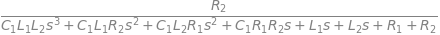

In [11]:
H_sym = (U_sym[v2]/U_sym[v1]).nsimplify().simplify().expand().together()
H_sym

In [12]:
H_sym_num, H_sym_denom = fraction(H_sym) #returns numerator and denominator

Solve for the roon of the numerator.

In [13]:
H_sym_num_roots = solve(H_sym_num,s)

Display the first solution.

In [14]:
#H_sym_num_roots[0]

Solve for the roots of the denominator.

In [15]:
H_sym_denom_roots = solve(H_sym_denom,s)

Display the first solution.

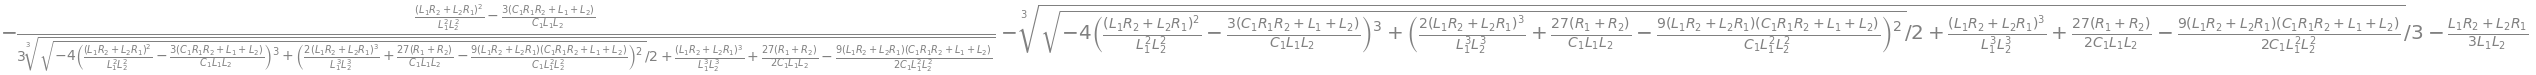

In [16]:
H_sym_denom_roots[0]

## Numerical solution

In [17]:
NE = NE_sym.subs(element_values)
U = solve(NE,X)

temp = ''
for i in U.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U[i]))

Markdown(temp)

$v_{1} = 1.0$<br>$v_{2} = \frac{1}{2.0 s^{3} + 4.0 s^{2} + 4.0 s + 2.0}$<br>$v_{3} = \frac{2.0 s^{3} + 2.0 s^{2} + 2.0 s + 1.0}{2.0 s^{3} + 4.0 s^{2} + 4.0 s + 2.0}$<br>$v_{4} = \frac{1}{2.0 s^{2} + 2.0 s + 2.0}$<br>$I_{V1} = \frac{- 2.0 s^{2} - 2.0 s - 1.0}{2.0 s^{3} + 4.0 s^{2} + 4.0 s + 2.0}$<br>$I_{L1} = \frac{2.0 s^{2} + 2.0 s + 1.0}{2.0 s^{3} + 4.0 s^{2} + 4.0 s + 2.0}$<br>$I_{L2} = \frac{1}{2.0 s^{3} + 4.0 s^{2} + 4.0 s + 2.0}$<br>

## DC operating point

In [18]:
NE = NE_sym.subs(element_values)
NE_dc = NE.subs({s:0})

Display the equations with numeric values.

In [19]:
temp = ''
for i in range(shape(NE_dc.lhs)[0]):
    temp += '${:s} = {:s}$<br>'.format(latex(NE_dc.rhs[i]),latex(NE_dc.lhs[i]))

Markdown(temp)

$0 = I_{V1} + 1.0 v_{1} - 1.0 v_{3}$<br>$0 = - I_{L2} + 1.0 v_{2}$<br>$0 = I_{L1} - 1.0 v_{1} + 1.0 v_{3}$<br>$0 = - I_{L1} + I_{L2}$<br>$1.0 = v_{1}$<br>$0 = v_{3} - v_{4}$<br>$0 = - v_{2} + v_{4}$<br>

Solve for voltages and currents.

In [20]:
U_dc = solve(NE_dc,X)

Display the numerical solution

In [21]:
table_header = ['unknown', 'mag']
table_row = []

for name, value in U_dc.items():
    table_row.append([str(name),float(value)])

print(tabulate(table_row, headers=table_header,colalign = ('left','decimal'),tablefmt="simple",floatfmt=('5s','.6f')))

unknown          mag
---------  ---------
v1          1.000000
v2          0.500000
v3          0.500000
v4          0.500000
I_V1       -0.500000
I_L1        0.500000
I_L2        0.500000


## AC analysis
Solve equations for $\omega$ equal to 1 radian per second, s = 1j.

In [40]:
# calculate Hz and radians
omega = 1 # frequency in radians per second
print('omega of {:.1f} rad/sec = {:.3f} Hz'.format(omega,omega/(2*np.pi)))

freq = 1 # frequency in cycles per second, Hz
print('frequency of {:.1f} Hz = {:.3f} rad/sec'.format(freq,freq*2*np.pi))

omega of 1.0 rad/sec = 0.159 Hz
frequency of 1.0 Hz = 6.283 rad/sec


In [22]:
NE = NE_sym.subs(element_values)
NE_w1 = NE.subs({s:1j})

Display the equations with numeric values.

In [23]:
temp = ''
for i in range(shape(NE_w1.lhs)[0]):
    temp += '${:s} = {:s}$<br>'.format(latex(NE_w1.rhs[i]),latex(NE_w1.lhs[i]))

Markdown(temp)

$0 = I_{V1} + 1.0 v_{1} - 1.0 v_{3}$<br>$0 = - I_{L2} + 1.0 v_{2}$<br>$0 = I_{L1} - 1.0 v_{1} + 1.0 v_{3}$<br>$0 = - I_{L1} + I_{L2} + 2.0 i v_{4}$<br>$1.0 = v_{1}$<br>$0 = - 1.0 i I_{L1} + v_{3} - v_{4}$<br>$0 = - 1.0 i I_{L2} - v_{2} + v_{4}$<br>

Solve for voltages and currents.

In [24]:
U_w1 = solve(NE_w1,X)

Display the numerical solution

In [25]:
table_header = ['unknown', 'mag','phase, deg']
table_row = []

for name, value in U_w1.items():
    table_row.append([str(name),float(abs(value)),float(arg(value)*180/np.pi)])

print(tabulate(table_row, headers=table_header,colalign = ('left','decimal','decimal'),tablefmt="simple",floatfmt=('5s','.6f','.6f')))

unknown         mag    phase, deg
---------  --------  ------------
v1         1.000000      0.000000
v2         0.353553   -135.000000
v3         0.353553     45.000000
v4         0.500000    -90.000000
I_V1       0.790569    161.565051
I_L1       0.790569    -18.434949
I_L2       0.353553   -135.000000


## Transfer function

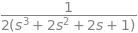

In [26]:
H = (U[v2]/U[v1]).nsimplify().simplify().expand().together()
H

Extract the numerator and denominator polynomials so that the system can be defined in SciPy.

In [27]:
H_num, H_denom = fraction(H) #returns numerator and denominator

The SciPy function, TransferFunction, represents the system as the continuous-time transfer function and takes as inputs the coeeficients of the numerator and denominator polynominals.

In [28]:
# convert symbolic to numpy polynomial
a = np.array(Poly(H_num, s).all_coeffs(), dtype=float)
b = np.array(Poly(H_denom, s).all_coeffs(), dtype=float)
sys = signal.TransferFunction(a,b)

## Poles and zeros of the transfer function
The poles and zeros of the transfer function can easly be obtained with the following code:

In [29]:
sys_zeros = np.roots(sys.num)
sys_poles = np.roots(sys.den)

## Pole zero plot

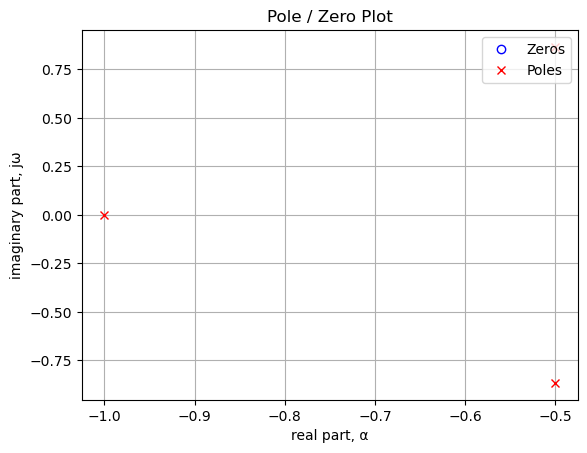

In [30]:
plt.plot(np.real(sys_zeros), np.imag(sys_zeros), 'ob', markerfacecolor='none')
plt.plot(np.real(sys_poles), np.imag(sys_poles), 'xr')
plt.legend(['Zeros', 'Poles'], loc=1)
plt.title('Pole / Zero Plot')
plt.xlabel('real part, \u03B1')
plt.ylabel('imaginary part, j\u03C9')
plt.grid()
plt.show()

Poles and zeros of the transfer function plotted on the complex plane. The units are in radian frequency.

Printing these values in Hz.

In [31]:
print('number of zeros: {:d}'.format(len(sys_zeros)))
for i in sys_zeros:
    print('{:,.2f} Hz'.format(i/(2*np.pi)))

number of zeros: 0


In [32]:
print('number of poles: {:d}'.format(len(sys_poles)))
for i in sys_poles:
    print('{:,.2f} Hz'.format(i/(2*np.pi)))

number of poles: 3
-0.16+0.00j Hz
-0.08+0.14j Hz
-0.08-0.14j Hz


## Bode plot

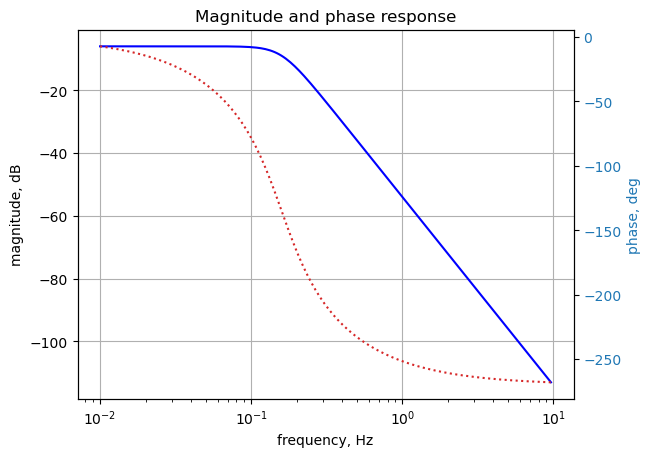

In [33]:
x = np.logspace(-2, 1, 200, endpoint=False)*2*np.pi
w, mag, phase = signal.bode(sys, w=x) # returns: rad/s, mag in dB, phase in deg

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(w/(2*np.pi), mag,'-b')    # Bode magnitude plot

ax1.tick_params(axis='y')
#ax1.set_ylim((-30,20))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

plt.semilogx(w/(2*np.pi), phase,':',color='tab:red')  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

plt.title('Magnitude and phase response')
plt.show()

## Impulse and step response

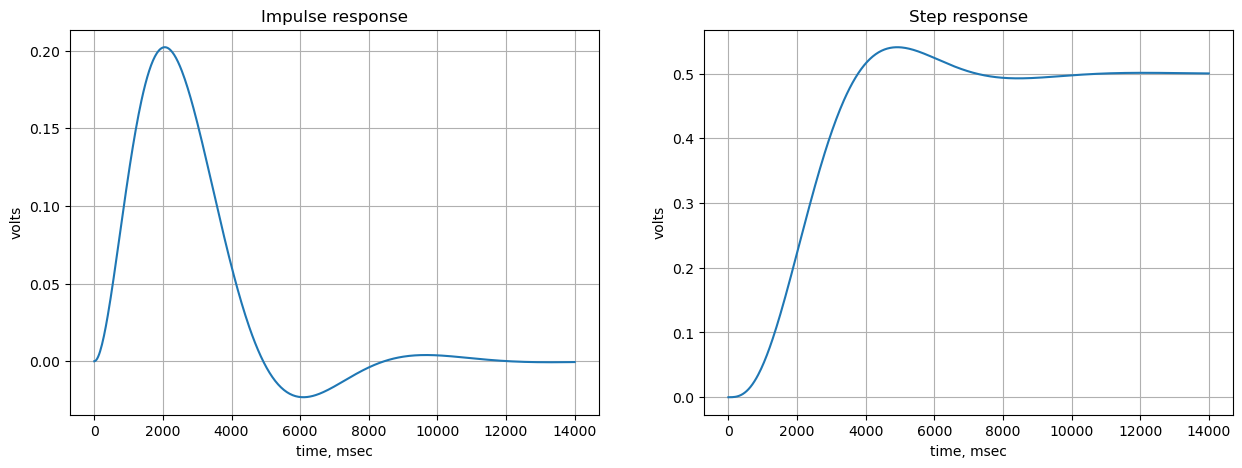

In [34]:
plt.subplots(1,2,figsize=(15, 5))

# using subplot function and creating
# plot one
plt.subplot(1, 2, 1)

# impulse response
t, y = signal.impulse(sys,N=500)
plt.plot(t/1e-3, y)
plt.title('Impulse response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()

# using subplot function and creating plot two
plt.subplot(1, 2, 2)

t, y = signal.step(sys,N=500)
plt.plot(t/1e-3, y)
plt.title('Step response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()

# show plot
plt.show()